Reference: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

In [0]:
import numpy as np
from numpy import array
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
cd drive/My Drive/Colab Notebooks
# change to the directory where you want to keep all files of the code

/content/drive/My Drive/Colab Notebooks


In [0]:
PATH=os.path.abspath('/content/drive/My Drive/Colab Notebooks')
annotation_t=PATH+'/train.json'
annotation_v=PATH+'/val.json'
with open(annotation_t, 'r') as f:
    annotations_t = json.load(f)
    
with open(annotation_v, 'r') as f:
    annotations_v = json.load(f)
all_img_name_vector_t= []
all_img_name_vector_v= []
mapping= dict()

for annot in annotations_t['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_image_path = PATH + '/train/VizWiz_train_' + '%08d.jpg' % (image_id)
    image_id_f='VizWiz_train_' + '%08d' % (image_id)
    if caption!='<start> Quality issues are too severe to recognize visual content <end>':
        if image_id not in mapping:
            mapping[image_id_f] = list()
        mapping[image_id_f].append(caption)
        all_img_name_vector_t.append(full_image_path)
PATH=os.path.abspath('/content')
descriptions=mapping
mapping2=dict()
for annot in annotations_v['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']-23431
    full_image_path = PATH + '/val/VizWiz_val_' + '%08d.jpg' % (image_id)
    image_id_v='VizWiz_val_' + '%08d' % (image_id)
    if caption!='<start> Quality issues are too severe to recognize visual content. <end>':
        if image_id not in mapping2:
            mapping2[image_id_v] = list()
        mapping2[image_id_v].append(caption)
        all_img_name_vector_v.append(full_image_path)

descriptions_val=mapping2

In [0]:
print('Loaded: %d ' % len(descriptions_val))
list(descriptions_val.keys())[:5]

Loaded: 7558 


['VizWiz_val_00000000',
 'VizWiz_val_00000001',
 'VizWiz_val_00000002',
 'VizWiz_val_00000003',
 'VizWiz_val_00000004']

In [0]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [0]:
print('Loaded: %d ' % len(descriptions))
print('Loaded: %d ' % len(descriptions_val))

Loaded: 23431 
Loaded: 7558 


In [0]:
list(descriptions.keys())[:5]

['VizWiz_train_00000000',
 'VizWiz_train_00000001',
 'VizWiz_train_00000002',
 'VizWiz_train_00000003',
 'VizWiz_train_00000004']

In [0]:
descriptions['VizWiz_train_00006678']
descriptions_val['VizWiz_val_00003748']

['<start> A mug, can of soup, and coffee container on a dark marble counter top <end>']

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)
clean_descriptions(descriptions_val)

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))
vocabulary_val = to_vocabulary(descriptions_val)
print('Original Vocabulary Size: %d' % len(vocabulary_val))

Original Vocabulary Size: 10128
Original Vocabulary Size: 6218


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(str(key) + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
save_descriptions(descriptions_val, 'descriptions_val.txt')
save_descriptions(descriptions, 'descriptions.txt')

In [0]:
val=set(descriptions_val.keys())
train =set(descriptions.keys())
print('Dataset: %d' % len(val))
print('Dataset: %d' % len(train))

Dataset: 7558
Dataset: 23431


In [0]:
train_img=all_img_name_vector_t
# train_img
val_img=all_img_name_vector_v
# val_img

In [0]:
# len(train_img)
len(val_img)

33583

In [0]:
val_img

['/content/val/VizWiz_val_00000000.jpg',
 '/content/val/VizWiz_val_00000000.jpg',
 '/content/val/VizWiz_val_00000000.jpg',
 '/content/val/VizWiz_val_00000000.jpg',
 '/content/val/VizWiz_val_00000000.jpg',
 '/content/val/VizWiz_val_00000001.jpg',
 '/content/val/VizWiz_val_00000001.jpg',
 '/content/val/VizWiz_val_00000001.jpg',
 '/content/val/VizWiz_val_00000001.jpg',
 '/content/val/VizWiz_val_00000001.jpg',
 '/content/val/VizWiz_val_00000002.jpg',
 '/content/val/VizWiz_val_00000002.jpg',
 '/content/val/VizWiz_val_00000002.jpg',
 '/content/val/VizWiz_val_00000002.jpg',
 '/content/val/VizWiz_val_00000002.jpg',
 '/content/val/VizWiz_val_00000003.jpg',
 '/content/val/VizWiz_val_00000003.jpg',
 '/content/val/VizWiz_val_00000003.jpg',
 '/content/val/VizWiz_val_00000003.jpg',
 '/content/val/VizWiz_val_00000003.jpg',
 '/content/val/VizWiz_val_00000004.jpg',
 '/content/val/VizWiz_val_00000004.jpg',
 '/content/val/VizWiz_val_00000004.jpg',
 '/content/val/VizWiz_val_00000004.jpg',
 '/content/val/V

In [0]:
train_img

['/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000000.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000000.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000000.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000000.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000000.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000001.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000001.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000001.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000001.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000001.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000002.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000002.jpg',
 '/content/drive/My Drive/Colab Notebooks/train/VizWiz_train_00000002.jpg',
 '/content/d

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
val_descriptions = load_clean_descriptions('descriptions_val.txt', val)
print('Descriptions: train=%d' % len(val_descriptions))

Descriptions: train=23431
Descriptions: train=7558


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 3s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    print(fea_vec.shape[0],fea_vec.shape[1])
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
images='/content/val/'

In [0]:
# Call the funtion to encode all the train images
start = time()
encoding_train = {}
# import itertools
# train_img_sub = train_img 
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [0]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_val = {}
for img in val_img:
    encoding_val[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Streaming output truncated to the last 5000 lines.
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 2048
1 20

In [0]:
 Save the bottleneck test features to disk
# f=open("encoded_train_images_3.pkl", "w")
import pickle
with open("/content/drive/My Drive/Colab Notebooks/encoded_train_images_3.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
#f=open("encoded_test_images.pkl", "w")
import pickle
with open("/home/user2/image_captioning/encoded_val_images3.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle)

'/content/drive/My Drive/Colab Notebooks'

In [0]:
val_features = load(open("/content/drive/My Drive/Colab Notebooks/encoded_val_images_3.pkl", "rb"))
print('Photos: train=%d' % len(val_features))

Photos: train=7558


In [0]:
train_features = load(open("/content/drive/My Drive/Colab Notebooks/encoded_train_images_3.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=23431


In [0]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

23431

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 10130 -> 1783


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1784

In [0]:

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 107


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
import itertools
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    descriptions = dict(itertools.islice(descriptions.items(), 30000)) 
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            key=key+'.jpg'
            if key in photos.keys():
                n+=1
                photo = photos[key]
                for desc in desc_list:
                    # encode the sequence
                    seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                    # split one sequence into multiple X, y pairs
                    for i in range(1, len(seq)):
                        # split into input and output pair
                        in_seq, out_seq = seq[:i], seq[i]
                        # pad input sequence
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        # encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        # store
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)


            # yield the batch data
            if n==num_photos_per_batch:
                X11=np.reshape(array(X1),(array(X1).shape[0],2048))
                yield [[X11, array(X2)], array(y)]
#                yield [ X11.shape]                
                X1, X2, y = list(), list(), list()
                n=0
    

In [0]:
# Load Glove vectors
glove_dir = '/content/drive/My Drive/Colab Notebooks/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(1784, 200)

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 107)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 107, 200)     356800      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])

model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
 import keras
 keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)


In [0]:
epochs = 2
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,initial_epoch=0)
    model.save('/content/drive/My Drive/Colab Notebooks/model_weights/model_' + str(i) + '.h5')

Epoch 1/1
976/976 [==============================] - 258s 265ms/step - loss: 2.5577
Epoch 1/1
976/976 [==============================] - 264s 271ms/step - loss: 2.5202


In [0]:
epochs = 2
number_pics_per_bath = 12
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,initial_epoch=0)
    model.save('/content/drive/My Drive/Colab Notebooks/model_weights/model_' + str(i+2) + '.h5')

Epoch 1/1
1952/1952 [==============================] - 502s 257ms/step - loss: 3.2775
Epoch 1/1
1952/1952 [==============================] - 497s 255ms/step - loss: 3.2406
Epoch 1/1


In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[2:-2]
    final = ' '.join(final)
    return final

In [0]:
model.load_weights('./Final/model_weights/model_8.h5')

In [0]:
images='/content/drive/My Drive/Colab Notebooks/Final/Sample_test/'

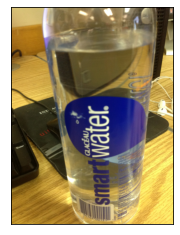

VizWiz_val_00001470.jpg
Prediction: bottle of water is on top of table


In [0]:
# Run these lines if you have the whole val set encoded in val_features and use z as the index of any dictionary item
# z=37
# pic = list(val_features.keys())[z]

# Run this to obtain results for a specific image
pic='VizWiz_val_00001470.jpg'


image = val_features[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.xticks([]),
plt.yticks([]),


plt.show()
print(pic)
print("Prediction:",greedySearch(image))
# print("Description:", descriptions_val[pic[:19]])

In [0]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate_model(photos):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions_val.items():
    # generate description
		yhat = greedySearch(photos[key+'.jpg'].reshape((1,2048)))
    # store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
    # calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [0]:
evaluate_model(val_features)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
